### Угадываем признак

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('athletes.csv')
data.head()

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11538 non-null  int64  
 1   name         11538 non-null  object 
 2   nationality  11538 non-null  object 
 3   sex          11538 non-null  object 
 4   dob          11537 non-null  object 
 5   height       11208 non-null  float64
 6   weight       10879 non-null  float64
 7   sport        11538 non-null  object 
 8   gold         11538 non-null  int64  
 9   silver       11538 non-null  int64  
 10  bronze       11538 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 991.7+ KB


Удалим строки с пустыми значениями

In [4]:
data = data[ pd.isnull( data['height'] ) == 0 ]
data = data[ pd.isnull( data['weight'] ) == 0 ]

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10858 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           10858 non-null  int64  
 1   name         10858 non-null  object 
 2   nationality  10858 non-null  object 
 3   sex          10858 non-null  object 
 4   dob          10858 non-null  object 
 5   height       10858 non-null  float64
 6   weight       10858 non-null  float64
 7   sport        10858 non-null  object 
 8   gold         10858 non-null  int64  
 9   silver       10858 non-null  int64  
 10  bronze       10858 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 1017.9+ KB


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

### Строим модель

In [7]:
X = data[['height', 'weight', 'sport', 'gold', 'silver', 'bronze']]
X.head(1)

,height,weight,sport,gold,silver,bronze
0,1.72,64.0,athletics,0,0,0


In [8]:
X = pd.get_dummies (X, columns = ['sport'])
X.head(1)

,height,weight,gold,silver,bronze,sport_aquatics,sport_archery,sport_athletics,sport_badminton,sport_basketball,...,sport_rugby sevens,sport_sailing,sport_shooting,sport_table tennis,sport_taekwondo,sport_tennis,sport_triathlon,sport_volleyball,sport_weightlifting,sport_wrestling
0,1.72,64.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [10]:
le.fit( data['sex'] )

LabelEncoder()

In [11]:
y = pd.Series( data = le.transform( data['sex'] ) )
y.head()

0    1
1    0
2    1
3    1
4    1
dtype: int32

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 

model = make_pipeline(StandardScaler(), LogisticRegression())

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [14]:
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

### Получаем прогнозные значения модели (переменная predictions)

In [15]:
predictions = model.predict_proba(X_test)
predictions[:2]

array([[0.47515789, 0.52484211],
       [0.90862865, 0.09137135]])

In [16]:
model.score(X_train, y_train)

0.8142105263157895

In [17]:
model.score(X_test, y_test)

0.8182934315531001

### Посчитаем tpr и fpr

In [57]:
tp = 0 # True positive
fp = 0 # False positive
fn = 0 # False negative
tn = 0 # True negative

predictions = model.predict_proba( X_test )
for predicted_prob, actual in zip( predictions[:, 1], y_test ):    
    if predicted_prob >= 0.5:
        predicted = 1
    else:
        predicted = 0
    
    if predicted == 1:
        if actual == 1:
            tp += 1
        else:
            fp += 1
    
    else:
        if actual == 1:
            fn += 1
        else:
            tn += 1

In [58]:
tp, fp, fn, tn

(1453, 288, 304, 1213)

In [59]:
tpr = tp / (tp + fn)
print('tpr =', tpr)

tpr = 0.8269778030734206


In [60]:
fpr = fp / (fp + tn)
print('fpr =', fpr)

fpr = 0.19187208527648233


### Убедимся, что график ROC AUC получается таким же, как и штатными средствами.

In [61]:
from sklearn.metrics import roc_curve

In [62]:
fpr, tpr, thres = roc_curve(y_test, predictions[:, 1])

In [63]:
from matplotlib import pyplot as plt

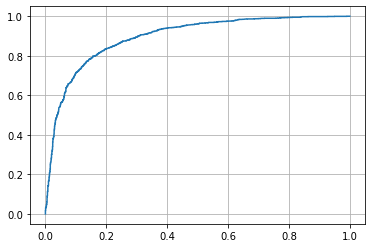

In [64]:
# График построенный штатными средствами
plt.plot( fpr, tpr )
plt.grid()

In [78]:
tpr1 = []
fpr1 = []
precision = []
recall = []

for threshold  in np.arange(0, 1, 0.01):
    tp = 0  # True positive
    fp = 0  # False positive
    fn = 0  # False negative
    tn = 0  # True negative

    predictions = model.predict_proba( X_test )
    for predicted_prob, actual in zip( predictions[:, 1], y_test ):    
        if predicted_prob >= threshold:
            predicted = 1
        else:
            predicted = 0

        if predicted == 1:
            if actual == 1:
                tp += 1
            else:
                fp += 1

        else:
            if actual == 1:
                fn += 1
            else:
                tn += 1
                
    tpr1.append(tp / (tp + fn))  
    fpr1.append(fp / (fp + tn)) 

    precision.append(tp / (tp + fp))
    recall.append(tp / (tp + fn))

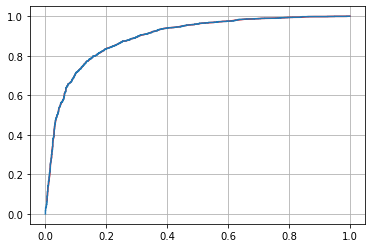

In [79]:
# График построенный штатными средствами - синий и график построенный по вычисленным значениям - красный.
plt.plot(fpr1, tpr1, color = 'red')
plt.plot( fpr, tpr )
plt.grid()
plt.show()

### Построим график Precision - Recall на этих же данных.

In [26]:
from sklearn.metrics import precision_recall_curve

In [27]:
pr, re, thres = precision_recall_curve(y_test, predictions[:, 1] )

In [28]:
# посмотрим что получилось
for line in zip( pr[:10], re[:10], thres[:10] ):
    print( line )

(0.5414483821263483, 1.0, 0.004597260647655969)
(0.5413070283600493, 0.9994308480364257, 0.004659290323414505)
(0.5414739438791243, 0.9994308480364257, 0.00472875048386721)
(0.5416409623689081, 0.9994308480364257, 0.00493091924171091)
(0.5418080839247146, 0.9994308480364257, 0.006363823297968619)
(0.5419753086419753, 0.9994308480364257, 0.006529839702171518)
(0.5421426366162396, 0.9994308480364257, 0.006704710653037279)
(0.5423100679431748, 0.9994308480364257, 0.0074470367100199315)
(0.5424776027185666, 0.9994308480364257, 0.007833541631725435)
(0.5426452410383189, 0.9994308480364257, 0.008090713590646037)


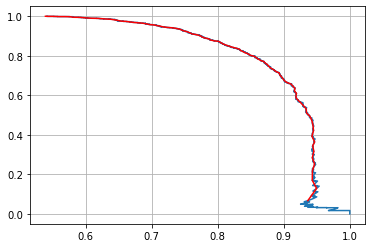

In [80]:
# График построенный штатными средствами - синий и график построенный по вычисленным значениям - красный.
plt.plot(pr,re)
plt.plot(precision, recall, color = 'red')
plt.grid()